In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F 
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import math
import copy
import nbimporter

In [29]:
df = pd.read_csv(r'D:\PROGRAMMING\BE proj24\dataset\angles.csv')
df.head()

,vid_id,frame_order,right_elbow_right_shoulder_right_hip,left_elbow_left_shoulder_left_hip,right_knee_mid_hip_left_knee,right_hip_right_knee_right_ankle,left_hip_left_knee_left_ankle,right_wrist_right_elbow_right_shoulder,left_wrist_left_elbow_left_shoulder
0,0,0,16.926802,7.667874,18.982162,112.747505,112.62553,112.099300,101.05565
1,0,1,14.199318,8.954973,18.966124,109.707190,109.76263,110.645454,102.00027
2,0,2,18.065800,10.315741,17.527954,114.562100,112.08965,113.340350,104.09502
3,0,3,23.270214,17.336140,17.195545,117.674810,115.43172,114.634530,107.38297
4,0,4,22.831680,13.822096,17.355429,117.536720,117.96766,112.306390,98.39078


DATA PRE-PROCESSING

In [30]:
squats_df=df[(df['vid_id']>=385)& (df['vid_id']<=447)]
squats_df.head(11817)

,vid_id,frame_order,right_elbow_right_shoulder_right_hip,left_elbow_left_shoulder_left_hip,right_knee_mid_hip_left_knee,right_hip_right_knee_right_ankle,left_hip_left_knee_left_ankle,right_wrist_right_elbow_right_shoulder,left_wrist_left_elbow_left_shoulder
72105,385,0,53.402206,73.528010,46.317870,149.35954,153.83890,118.31155,88.452630
72106,385,1,45.957460,81.406560,35.316982,118.72570,145.04758,108.92687,110.066660
72107,385,2,44.079243,79.323600,37.196740,103.62296,137.77670,103.73133,104.628716
72108,385,3,34.982906,78.514984,41.724506,86.89696,123.90274,93.21554,105.458960
72109,385,4,30.291750,78.184020,39.902603,87.05850,124.05390,87.08308,101.913830
...,...,...,...,...,...,...,...,...,...
83917,447,296,107.305360,90.115130,51.515130,134.34811,147.88246,136.57085,123.315970
83918,447,297,100.225420,94.343120,53.821750,146.84540,163.03261,140.31600,140.187360
83919,447,298,100.277790,89.232956,49.927440,137.95894,152.91435,136.71500,128.460190
83920,447,299,99.322820,87.257810,49.641770,148.99538,167.36041,138.74146,134.618380


In [31]:
#MISSING VALUES
squats_df.isna().sum()

vid_id                                    0
frame_order                               0
right_elbow_right_shoulder_right_hip      0
left_elbow_left_shoulder_left_hip         0
right_knee_mid_hip_left_knee              0
right_hip_right_knee_right_ankle          0
left_hip_left_knee_left_ankle             0
right_wrist_right_elbow_right_shoulder    0
left_wrist_left_elbow_left_shoulder       0
dtype: int64

In [32]:
batches = {vid_id: batch_df for vid_id, batch_df in squats_df.groupby('vid_id')}
print(batches[386])
batches[386].shape

       vid_id  frame_order  right_elbow_right_shoulder_right_hip  \
72297     386            0                             56.423603   
72298     386            1                             61.214800   
72299     386            2                             51.701412   
72300     386            3                             44.270763   
72301     386            4                             43.186565   
...       ...          ...                                   ...   
72410     386          113                             76.367775   
72411     386          114                             54.619583   
72412     386          115                             68.289276   
72413     386          116                             74.327680   
72414     386          117                             79.625984   

       left_elbow_left_shoulder_left_hip  right_knee_mid_hip_left_knee  \
72297                          95.398070                     56.581210   
72298                          94.7

(118, 9)

In [33]:
len(batches)

63

In [34]:
squats_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
vid_id,11817.0,417.327664,17.565843,385.000000,402.000000,418.000000,432.000000,447.00000
frame_order,11817.0,116.823644,75.504366,0.000000,54.000000,109.000000,171.000000,300.00000
right_elbow_right_shoulder_right_hip,11817.0,73.756246,38.049859,0.560928,45.767803,72.938470,98.881180,179.44572
left_elbow_left_shoulder_left_hip,11817.0,73.386426,35.835562,0.490588,46.047634,71.806760,97.040825,178.08286
right_knee_mid_hip_left_knee,11817.0,60.834624,33.177868,2.469024,33.025433,54.437340,83.618700,163.06690
right_hip_right_knee_right_ankle,11817.0,114.093814,44.773410,3.951906,72.267075,124.740340,154.146550,179.28098
left_hip_left_knee_left_ankle,11817.0,113.778740,44.036237,7.600006,74.012054,122.373184,153.115070,179.80415
right_wrist_right_elbow_right_shoulder,11817.0,128.509795,28.215010,1.055918,113.636250,131.309600,148.568850,179.03004
left_wrist_left_elbow_left_shoulder,11817.0,125.394389,30.405133,2.971638,108.255820,129.030030,148.296140,179.00612


In [35]:
sample_vid_id = 385
sample_batch = squats_df['vid_id']
sample_batch

72105    385
72106    385
72107    385
72108    385
72109    385
        ... 
83917    447
83918    447
83919    447
83920    447
83921    447
Name: vid_id, Length: 11817, dtype: int64

In [36]:
# Define the rolling window size (e.g., 20 frames)
rolling_window = 20

# Preprocess each batch: apply rolling mean, then normalize
preprocessed_batches = {}

for vid_id, batch in batches.items():
    print(f"video ID: {vid_id}")
    print(" batch before rolling mean:")
    print(batch.head())
    angle_columns = batch.columns[2:]
    batch[angle_columns] = batch[angle_columns].rolling(window=rolling_window, min_periods=1).mean()
    print("batch after applying rolling mean:")
    print(batch.head())
   
    # Store the preprocessed batch
    preprocessed_batches[vid_id] = batch

# Display the first batch to verify preprocessing
preprocessed_batches[385].head()


video ID: 385
 batch before rolling mean:
       vid_id  frame_order  right_elbow_right_shoulder_right_hip  \
72105     385            0                             53.402206   
72106     385            1                             45.957460   
72107     385            2                             44.079243   
72108     385            3                             34.982906   
72109     385            4                             30.291750   

       left_elbow_left_shoulder_left_hip  right_knee_mid_hip_left_knee  \
72105                          73.528010                     46.317870   
72106                          81.406560                     35.316982   
72107                          79.323600                     37.196740   
72108                          78.514984                     41.724506   
72109                          78.184020                     39.902603   

       right_hip_right_knee_right_ankle  left_hip_left_knee_left_ankle  \
72105                         

,vid_id,frame_order,right_elbow_right_shoulder_right_hip,left_elbow_left_shoulder_left_hip,right_knee_mid_hip_left_knee,right_hip_right_knee_right_ankle,left_hip_left_knee_left_ankle,right_wrist_right_elbow_right_shoulder,left_wrist_left_elbow_left_shoulder
72105,385,0,53.402206,73.528010,46.317870,149.359540,153.838900,118.311550,88.452630
72106,385,1,49.679833,77.467285,40.817426,134.042620,149.443240,113.619210,99.259645
72107,385,2,47.812970,78.086057,39.610531,123.902733,145.554393,110.323250,101.049335
72108,385,3,44.605454,78.193288,40.139024,114.651290,140.141480,106.046323,102.151741
72109,385,4,41.742713,78.191435,40.091740,109.132732,136.923964,102.253674,102.104159


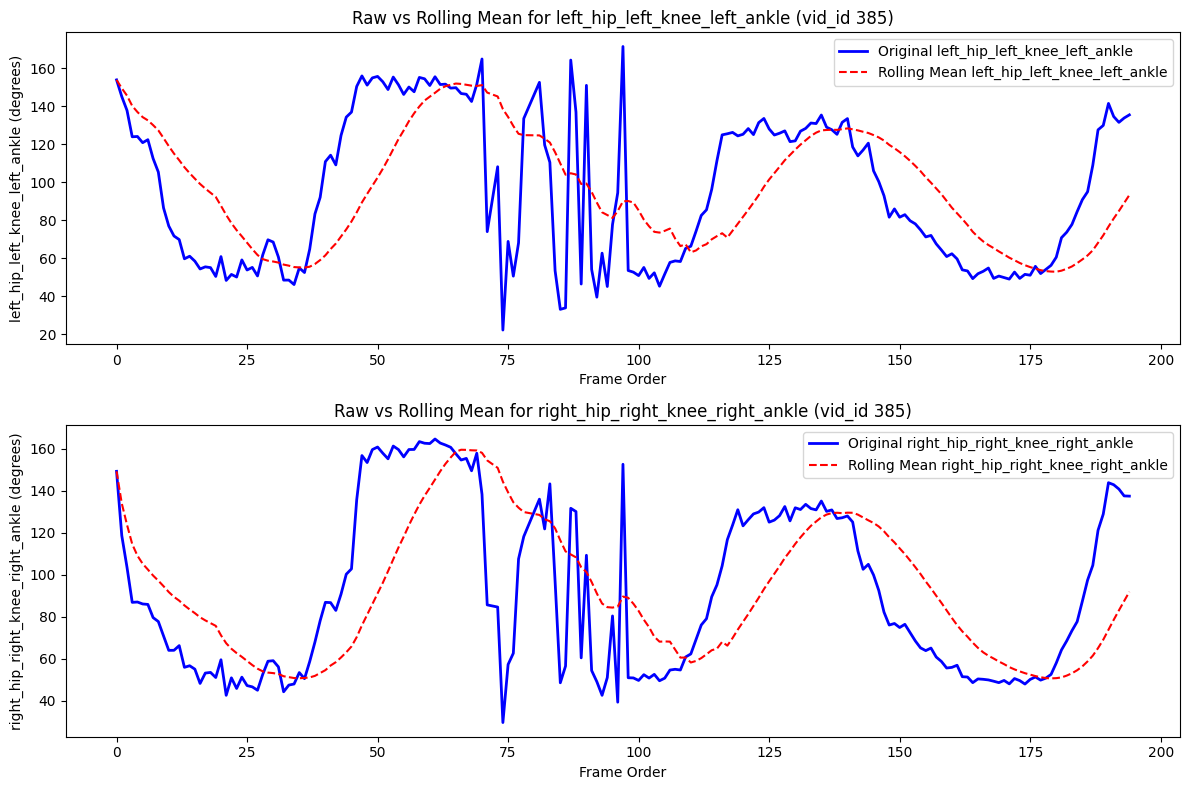

In [37]:
import matplotlib.pyplot as plt

# Sample video ID and batch
sample_vid_id = 385
sample_batch = preprocessed_batches[sample_vid_id]

# Angle columns to visualize
angle_columns = ['left_hip_left_knee_left_ankle', 'right_hip_right_knee_right_ankle']

# Create a figure with a larger size to avoid overlap
plt.figure(figsize=(12, 8))

# Loop through each angle column
for i, angle in enumerate(angle_columns):
    # Get the original data and the rolling mean (this was already calculated)
    original_data = squats_df[squats_df['vid_id'] == sample_vid_id][angle]
    rolling_mean = sample_batch[angle]  # This is the rolling mean from preprocessing

    # Create a subplot for each angle column
    plt.subplot(len(angle_columns), 1, i + 1)  # len(angle_columns) rows, 1 column

    # Plot the original data (raw data) - in blue, solid line
    plt.plot(sample_batch['frame_order'], original_data, label=f'Original {angle}', color='blue', linewidth=2)
    
    # Plot the rolling mean (smoothed data) - in red, dashed line
    plt.plot(sample_batch['frame_order'], rolling_mean, label=f'Rolling Mean {angle}', color='red', linestyle='--')

    # Add titles and labels
    plt.title(f'Raw vs Rolling Mean for {angle} (vid_id {sample_vid_id})')
    plt.xlabel('Frame Order')
    plt.ylabel(f'{angle} (degrees)')
    plt.legend()

# Adjust layout to avoid overlap and ensure spacing is correct
plt.tight_layout()
plt.show()


In [ ]:
scaler = MinMaxScaler()
preprocessed_batches = {}
for vid_id, batch in batches.items():
    
    # Normalize angle columns (excluding 'vid_id' and 'frame_order')
    
    batch.iloc[:, 2:] = scaler.fit_transform(batch.iloc[:, 2:])
    
    # Store the preprocessed batch
    preprocessed_batches[vid_id] = batch

# Show the first batch after preprocessing
preprocessed_batches[386].head(118)


,vid_id,frame_order,right_elbow_right_shoulder_right_hip,left_elbow_left_shoulder_left_hip,right_knee_mid_hip_left_knee,right_hip_right_knee_right_ankle,left_hip_left_knee_left_ankle,right_wrist_right_elbow_right_shoulder,left_wrist_left_elbow_left_shoulder
72297,386,0,0.925895,0.477429,1.000000,1.000000,0.850580,0.771602,0.949302
72298,386,1,1.000000,0.464064,0.887672,0.936402,0.889967,0.939492,0.913381
72299,386,2,0.926606,0.626753,0.708211,0.745572,0.903950,0.823551,0.929267
72300,386,3,0.832445,0.613243,0.603357,0.661858,0.884309,0.474508,0.900532
72301,386,4,0.769240,0.575307,0.567968,0.571172,0.878573,0.257767,0.922155
...,...,...,...,...,...,...,...,...,...
72410,386,113,0.647587,0.313635,0.279169,0.302388,0.519985,0.763523,0.839718
72411,386,114,0.698453,0.308234,0.346841,0.377609,0.568828,0.802165,0.833599
72412,386,115,0.752163,0.343391,0.398143,0.450696,0.614154,0.822183,0.824797
72413,386,116,0.816399,0.362771,0.449867,0.531087,0.677858,0.851727,0.832403


In [ ]:
# scaler = MinMaxScaler()
# squats_df.iloc[:, 2:] = scaler.fit_transform(squats_df.iloc[:, 2:])
# squats_df.head()


In [ ]:
A=squats_df.iloc[:,2:]
A

,right_elbow_right_shoulder_right_hip,left_elbow_left_shoulder_left_hip,right_knee_mid_hip_left_knee,right_hip_right_knee_right_ankle,left_hip_left_knee_left_ankle,right_wrist_right_elbow_right_shoulder,left_wrist_left_elbow_left_shoulder
72105,53.402206,73.528010,46.317870,149.35954,153.83890,118.31155,88.452630
72106,45.957460,81.406560,35.316982,118.72570,145.04758,108.92687,110.066660
72107,44.079243,79.323600,37.196740,103.62296,137.77670,103.73133,104.628716
72108,34.982906,78.514984,41.724506,86.89696,123.90274,93.21554,105.458960
72109,30.291750,78.184020,39.902603,87.05850,124.05390,87.08308,101.913830
...,...,...,...,...,...,...,...
83917,107.305360,90.115130,51.515130,134.34811,147.88246,136.57085,123.315970
83918,100.225420,94.343120,53.821750,146.84540,163.03261,140.31600,140.187360
83919,100.277790,89.232956,49.927440,137.95894,152.91435,136.71500,128.460190
83920,99.322820,87.257810,49.641770,148.99538,167.36041,138.74146,134.618380


In [ ]:
class ExerciseDataset(Dataset):
    def __init__(self, data):
        # self.data = data
        # self.r_data = data[df.iloc[:,2:]].values
        self.data = data
        # Define the columns for X and y
        self.columns = [
            'right_elbow_right_shoulder_right_hip', 
            'left_elbow_left_shoulder_left_hip', 
            'right_knee_mid_hip_left_knee', 
            'right_hip_right_knee_right_ankle', 
            'left_hip_left_knee_left_ankle', 
            'right_wrist_right_elbow_right_shoulder', 
            'left_wrist_left_elbow_left_shoulder'
        ]
        # Extract only these columns from the DataFrame
        self.r_data = data[self.columns].values
    def __len__(self):
        # Since y is the next frame, we have one less sample in y
        return len(self.data) - 1

    def __getitem__(self, idx):
        # X is the current frame, y is the next frame in the sequence
        X = torch.tensor(self.r_data[idx], dtype=torch.float32)
        y = torch.tensor(self.r_data[idx + 1], dtype=torch.float32)  # Next frame as target
        return X, y



In [ ]:
total_rows = squats_df.shape[0]
BATCH_SIZE=64

# Define an 80-20 split
train_size = int(0.8 * total_rows)
train_videos = squats_df[:train_size]
test_videos = squats_df[train_size:]

# Check the size of the splits
len(train_videos), len(test_videos)


(9453, 2364)

In [ ]:
# Pass the train and test DataFrames into the custom Dataset
train_dataset = ExerciseDataset(train_videos)
test_dataset = ExerciseDataset(test_videos)

# Create DataLoaders from the datasets
train_dataloader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False)


In [ ]:
for i, batch in enumerate(train_dataloader):
    print(f"Batch {i}:")
    print(batch)
    if i == 0:  # Change 2 to the number of batches you'd like to preview
        break

Batch 0:
[tensor([[  9.3074,  44.7793,  78.6600, 168.9931, 163.2560, 123.5477, 155.0344],
        [ 51.9913,  69.0434,  54.6215, 160.3801, 170.5686, 124.0499, 138.9237],
        [ 39.1200,  65.7458,  19.8358, 164.5745, 152.7050, 140.4473, 139.3833],
        [ 48.4618,  70.1993,  41.5081, 135.7936, 150.3895, 115.9347,  88.3235],
        [ 81.8570,  71.0015,  25.0109, 171.3720, 168.3184, 129.0355, 114.7450],
        [ 61.1035,  98.4246,  61.8931, 149.9332, 156.4308, 128.2526, 156.1281],
        [ 47.7033,   5.1366,  71.7020, 123.3513, 123.3447, 100.7151,  94.6337],
        [132.4445, 113.5166,  74.7363,  61.0847,  83.7614, 138.2594, 123.0790],
        [ 46.8807,  23.6421,  31.1063, 173.0070, 168.4810, 118.8737, 106.6834],
        [ 76.2207,  54.3289,  95.3995,  72.2379,  87.7090, 109.8630,  98.3936],
        [ 74.3277, 105.0803,  55.6582, 153.0531, 158.7193, 173.1647, 152.9262],
        [ 10.2451,  30.3900,  79.8925,  90.1086,  73.9070, 139.7419, 149.5898],
        [ 30.7586, 103.5528,  

In [ ]:
print(train_dataset)

In [ ]:
next(iter(train_dataloader))

[tensor([[ 96.8416,  96.2791,  24.0410, 138.3150, 132.7870, 125.9445, 127.7985],
         [ 84.4122, 110.1688,  98.3703, 159.4085, 145.3201, 145.1994, 148.6832],
         [ 96.5804,  52.6420,  76.2896,  92.0893,  91.4348, 113.4339,  84.7382],
         [ 72.1503,  72.5219,  36.3262, 132.9842, 133.1009, 135.9967, 140.8884],
         [ 67.9643,  57.1141,  57.7368, 173.1242, 176.3045, 116.8831, 119.8622],
         [ 89.1332, 123.8868,  59.7078,  58.7940,  71.2959, 108.3132, 161.1541],
         [ 74.9628,  79.8049,  24.9113,  68.6942,  68.7956, 123.9935, 123.9709],
         [ 99.6969,  99.6760,  99.3037, 120.6374,  90.6866, 167.3942,  66.3431],
         [ 51.9409,  75.3200,  37.2438, 165.5279, 168.3507, 145.5999,  99.9725],
         [ 57.5697,  89.4556, 125.2743,  78.9810, 129.7167,  75.3725, 135.0092],
         [ 70.1240,  63.2880,  35.9427, 134.3453, 128.4863,  94.4637, 104.7449],
         [ 91.0381,  86.9302,  33.1278, 109.7576, 109.9531, 135.7878, 121.7980],
         [ 51.7648,  55.0073

In [ ]:
train_videos.shape

(9453, 9)

In [ ]:
test_videos.shape

(2364, 9)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(7, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 7),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits


In [ ]:
model = NeuralNetwork().to(device)
print(model)


NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=7, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=7, bias=True)
  )
)


In [ ]:
loss_fn = nn.MSELoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [ ]:
def r_squared(y, pred):
    # Calculate the total sum of squares
    ss_total = torch.sum((y - torch.mean(y)) ** 2)
    
    # Calculate the residual sum of squares
    ss_residual = torch.sum((y -pred) ** 2)
    
    # Calculate R-squared
    r2 = 1 - (ss_residual / ss_total)
    
    return r2

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


In [ ]:
size = len(train_dataloader.dataset)
size

9452

In [ ]:
iter(test_dataloader)

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for i in range(0, len(dataloader), BATCH_SIZE):
            for X, y in dataloader:
                X, y = X.to(device), y.to(device)
                data=X
                targets =y
                pred = model(data)           
                total_loss += loss_fn(pred, torch.mean(y, dim=0).unsqueeze(0)).item()
                r2 = r_squared(y,pred)
            print(f"Total loss:\n R2 score: {r2}, Avg loss: {total_loss:>8f} \n")
    return total_loss / len(dataloader),r2
            


In [ ]:
epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)



Epoch 1
-------------------------------
loss: 11805.572266  [   64/ 9452]
loss:     nan  [ 6464/ 9452]


c:\Users\siddh\.conda\envs\testenv\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 7])) that is different to the input size (torch.Size([64, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\siddh\.conda\envs\testenv\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 7])) that is different to the input size (torch.Size([59, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Total loss:
 R2 score: nan, Avg loss:      nan 

Epoch 2
-------------------------------
loss:     nan  [   64/ 9452]
loss:     nan  [ 6464/ 9452]
Total loss:
 R2 score: nan, Avg loss:      nan 

Epoch 3
-------------------------------
loss:     nan  [   64/ 9452]
loss:     nan  [ 6464/ 9452]
Total loss:
 R2 score: nan, Avg loss:      nan 

Epoch 4
-------------------------------
loss:     nan  [   64/ 9452]
loss:     nan  [ 6464/ 9452]
Total loss:
 R2 score: nan, Avg loss:      nan 

Epoch 5
-------------------------------
loss:     nan  [   64/ 9452]
loss:     nan  [ 6464/ 9452]
Total loss:
 R2 score: nan, Avg loss:      nan 

Epoch 6
-------------------------------
loss:     nan  [   64/ 9452]
loss:     nan  [ 6464/ 9452]
Total loss:
 R2 score: nan, Avg loss:      nan 

Epoch 7
-------------------------------
loss:     nan  [   64/ 9452]
loss:     nan  [ 6464/ 9452]
Total loss:
 R2 score: nan, Avg loss:      nan 

Epoch 8
-------------------------------
loss:     nan  [   64/ 9452]


In [ ]:
# Save the model
model_path = 'data.pth'
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")


Model saved to data.pth


In [ ]:
def predict_future(model, dataloader):
    model.eval()   
    with torch.no_grad():
        for X, y in dataloader:
                X, y = X.to(device), y.to(device)
                data=X
                targets =y
                pred = model(data)
                print(pred)
                break
predict_future(model, test_dataloader)

tensor([[nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan],
        [n

In [ ]:
model = NeuralNetwork().to(device)  # Create a new instance of your model
model.load_state_dict(torch.load(model_path))  # Load the saved state dict
model.eval()  # Set the model to evaluation mode
print("Model loaded successfully.")

Model loaded successfully.


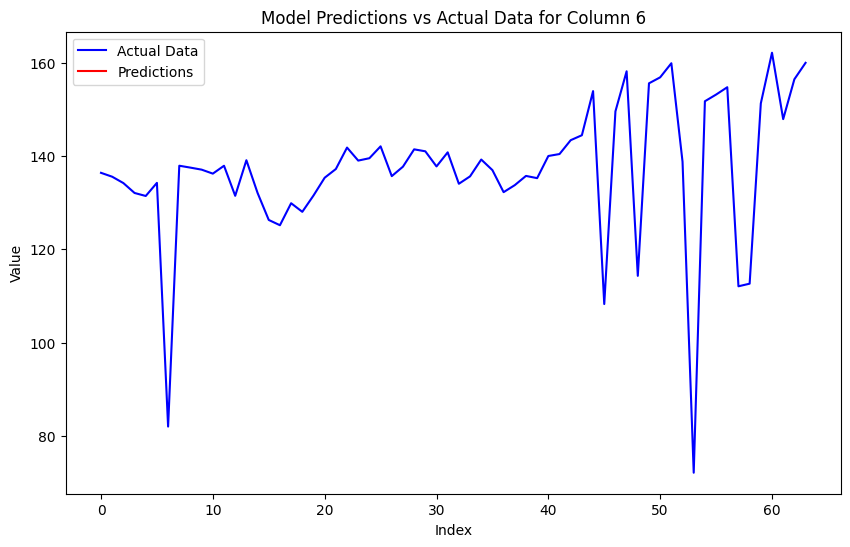

In [ ]:
# Define which batch and column to visualize
pred_batch_num = 1  # Index of batch to visualize (first batch in this case)
col_id = 6 # Column index to visualize within the data

dataloader_iter = iter(test_dataloader)


for _ in range(pred_batch_num):
    next(dataloader_iter)

# Now, retrieve the specified batch
X, y = next(dataloader_iter)
X, y = X.to(device), y.to(device)

# Make predictions using the model
pred = model(X)

# Move predictions and actual values back to CPU for plotting
pred = pred.cpu().detach().numpy()
y = y.cpu().detach().numpy()


# Visualize the specified column in the batch
plt.figure(figsize=(10, 6))

# Plot the actual target data for the specified column
plt.plot(y[:, col_id], label='Actual Data', color='blue')

# Plot the model's predictions for the same column
plt.plot(pred[:, col_id], label='Predictions', color='red')

# Additional plot settings
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.title('Model Predictions vs Actual Data for Column {}'.format(col_id))
plt.show()


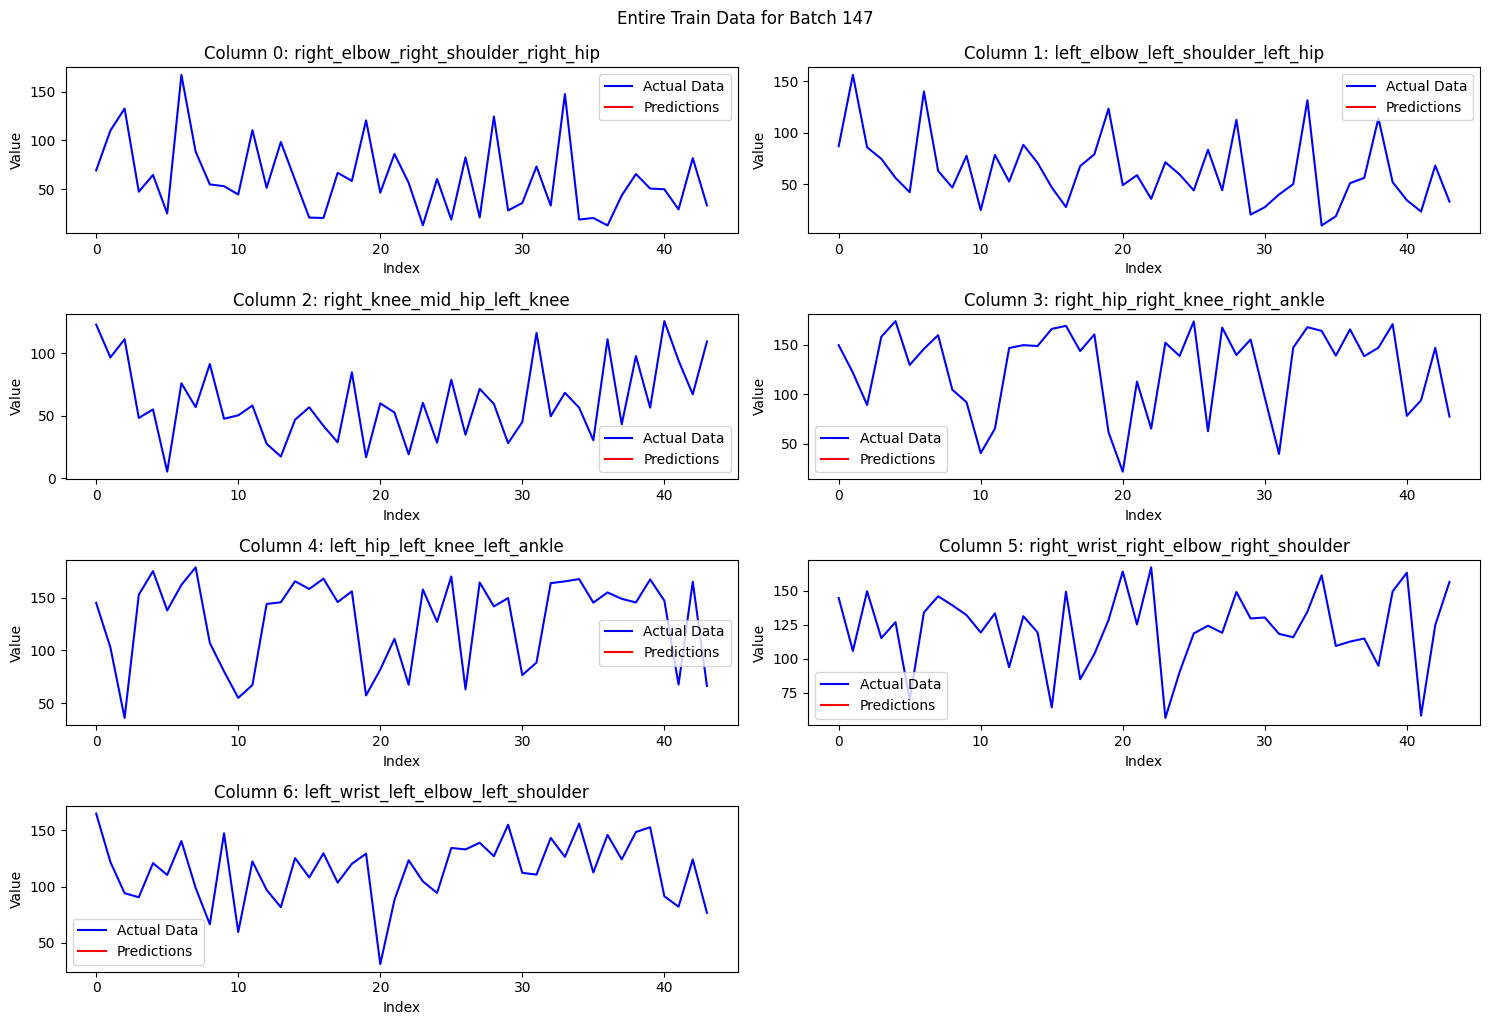

In [ ]:
# Convert the train_dataloader to a list to access batches by index directly
train_dataloader_list = list(train_dataloader)

# Define the batch number to visualize
train_batch_num = 147  # Specify the batch number you want to visualize

# Retrieve the specified batch directly
X, y = train_dataloader_list[train_batch_num]
X, y = X.to(device), y.to(device)

# Make predictions using the model
pred = model(X)

# Move predictions and actual values back to CPU for plotting
pred = pred.cpu().detach().numpy()
y = y.cpu().detach().numpy()

# Plot the entire train data for the specified batch across all columns (angles)
plt.figure(figsize=(15, 10))

# Loop through each column (angle) and plot it
for col_id in range(y.shape[1]):
    plt.subplot(4, 2, col_id + 1)  # Create subplots for each column
    plt.plot(y[:, col_id], label='Actual Data', color='blue')
    plt.plot(pred[:, col_id], label='Predictions', color='red')
    plt.title(f'Column {col_id}: {train_dataset.columns[col_id]}')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()

plt.tight_layout()
plt.suptitle(f'Entire Train Data for Batch {train_batch_num}', y=1.02)
plt.show()


In [ ]:
# # Calculate the maximum batch number
# train_batch_num = len(train_dataloader) - 1
# print(f"train_batch_num: {train_batch_num}")
